<a href="https://colab.research.google.com/github/gluckt/covid19-exploration/blob/main/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# setup
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

## 1.	What is the relationship between cases, hospitalizations, and deaths? Describe how these indicators relate to each other, and visualize the relationships in at least 2 different ways.

In [ ]:
# load data
covid_data = pd.read_csv("/content/drive/MyDrive/covid_data_cases_deaths_hosp.csv")
covid_data.head()

,location_id,Province/State,Country/Region,Date,Confirmed,Deaths,population,Hospitalizations,US STATE
0,102,NaN,United States of America,43885,36.0,0.0,327978729.9,NaN,1
1,102,NaN,United States of America,43886,36.0,0.0,327978729.9,NaN,1
2,102,NaN,United States of America,43887,42.0,0.0,327978729.9,NaN,1
3,102,NaN,United States of America,43888,42.0,0.0,327978729.9,NaN,1
4,102,NaN,United States of America,43889,44.0,0.0,327978729.9,NaN,1


In [ ]:
# Relevant vars
#   Confirmed = cumulative confirmed (reported) cases of Covid-19
#   Deaths = cumulative reported deaths due to Covid-19
#   Hospitalizations = cumulative hospitalizations due to Covid-19
#   population = Population of each location

# Do some renaming for convenience 
covid_data = covid_data.rename(columns={"Date" : "date", "Confirmed" : "cases", "Deaths" : "deaths", "population" : "pop", "Hospitalizations": "hosp",
                           "Province/State" : "state"})

# dataset contains metrics on national/subnational level, so let's split those up
covid_data_nat = covid_data.loc[covid_data['location_id'] == 102]
covid_data_subnat = covid_data.loc[covid_data['location_id'] != 102]


Text(0.5, 0.9, 'Covid-19 Indicators by US State (log scale)')

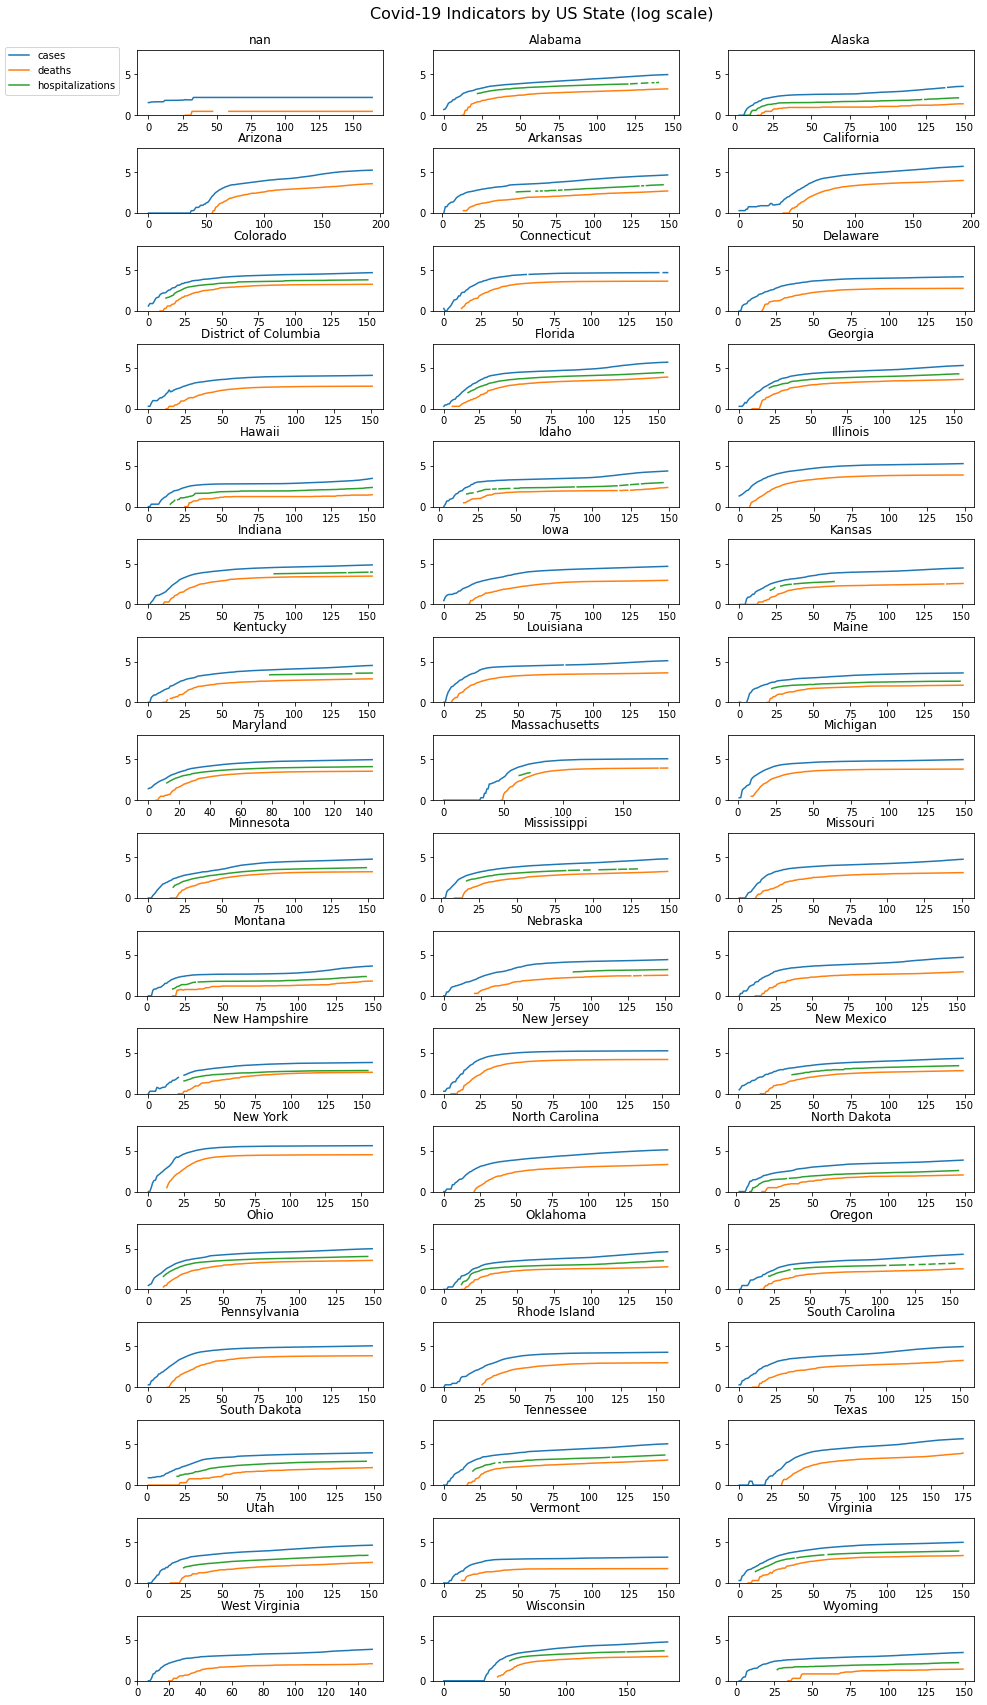

In [ ]:
# Firstly, let's plot a simple line graph of each indicator over time to get a sense of what's happening
# We will also convert each to a log scale since we are interested in the relative growth patterns of each indicator, and upon
#   inspection the magnitude of cases vastly outnumbers hospitalizations and deaths. 
np.seterr(all="ignore")
fig = plt.figure(figsize=(15,30))
plt.subplots_adjust(hspace=0.5)
loc_ids = covid_data.location_id.unique()
labels =['cases', 'deaths', 'hospitalizations']
for n, loc_id in enumerate(loc_ids):
    ax = plt.subplot(17,3,n+1)

    df = covid_data.loc[covid_data.location_id == loc_id]
    t1 = df['date'].values
    t1 = t1 - np.min(t1) # adjust so this shows number of days from 0 to n
    y1 = np.log10(df['cases'].values)
    y2 = np.log10(df['deaths'].values)
    y3 = np.log10(df['hosp'].values)
    plt.plot(t1,y1, label="cases")
    plt.plot(t1,y2, label="deaths")
    plt.plot(t1,y3, label="hospitalizations")
    plt.ylim(0,8)
    ax.set_title(df['state'].unique()[0])

    # ax.set_xticklabels([])


fig.legend(labels, loc="upper left", bbox_to_anchor = (0,0.77))
fig.suptitle("Covid-19 Indicators by US State (log scale)", y = 0.9, fontsize=16)

Text(0.5, 0.9, 'Covid-19 Scaled Deaths/Case ratio and Hospitalizations')

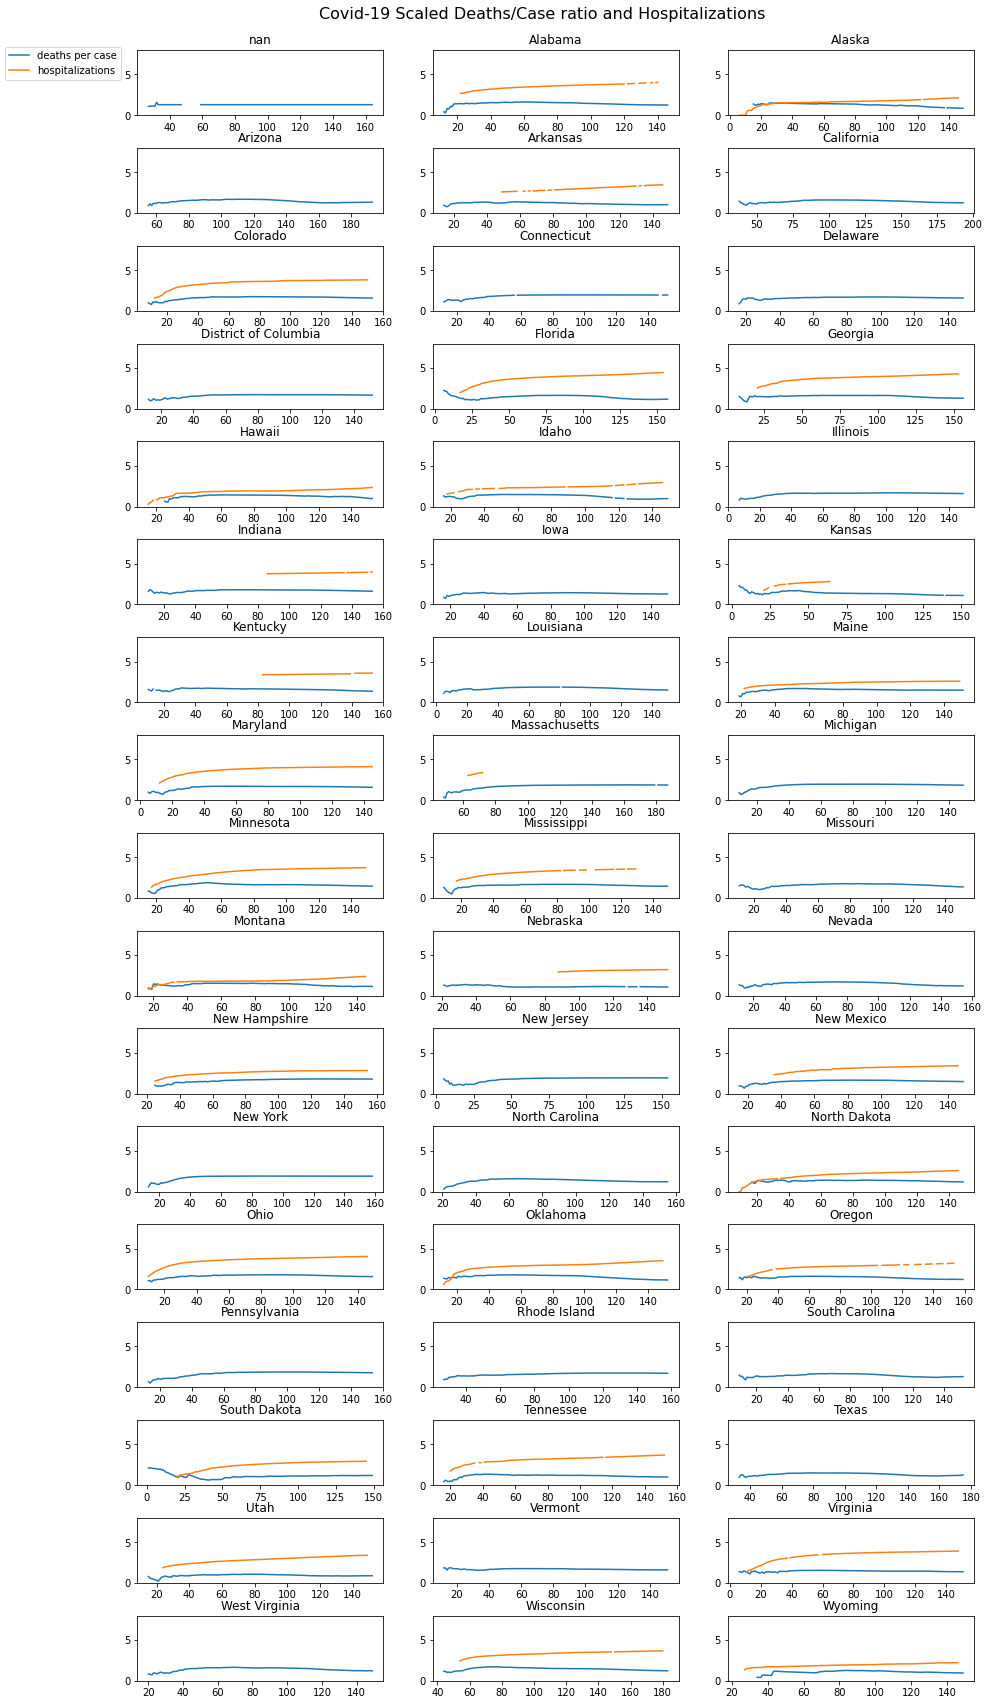

In [ ]:
# Next we could also consider the ratio of deaths/cases and how that rate changes over time in relation to total hospitalization
# We will also scale this ratio so that it appears on the log scale. 
covid_data = covid_data.assign(dh_ratio = 1000*covid_data.deaths/covid_data.cases)
np.seterr(all="ignore")
fig = plt.figure(figsize=(15,30))
plt.subplots_adjust(hspace=0.5)
loc_ids = covid_data.location_id.unique()
labels =['deaths per case', 'hospitalizations']
for n, loc_id in enumerate(loc_ids):
    ax = plt.subplot(17,3,n+1)

    df = covid_data.loc[covid_data.location_id == loc_id]
    t1 = df['date'].values
    t1 = t1 - np.min(t1) # adjust so this shows number of days from 0 to n
    y1 = np.log10(df['dh_ratio'].values)
    y3 = np.log10(df['hosp'].values)
    plt.plot(t1,y1, label="deaths per case")
    plt.plot(t1,y3, label="hospitalizations")
    plt.ylim(0,8)
    ax.set_title(df['state'].unique()[0])



fig.legend(labels, loc="upper left", bbox_to_anchor = (0,0.77))
fig.suptitle("Covid-19 Scaled Deaths/Case ratio and Hospitalizations", y = 0.9, fontsize=16)

1. From these two sets of vizualizations we can clearly see that each of the three indicators we are interested in are positively correlated. Following an increase in cases there is a clear increase in both deaths and hospitalizations. Each indicator exhibits exponential growth at the onset, and then slows down to a linear rate. When looking at deaths per case, we see that they tend to decrease at the onset as hospitalizations begin to increase. From there it is difficult to conclude anything else further as the death per case ratio varies by state, but shows little variance through the remainder of the time series. 

## 2.	Fit a curve of daily deaths, utilizing these inputs. Describe the approach you used and visualize the results.


In [ ]:
# We will first try this with one loc_id
loc_id = 541

# first calculate daily deaths. We can take the difference between each step of cumulative deaths.
df = covid_data.loc[covid_data.location_id == loc_id]
cum_deaths = df.deaths.values
daily_deaths = np.empty(len(cum_deaths))
daily_deaths[0] = cum_deaths[0]
for i in range(len(daily_deaths)):
    if i==0:
        daily_deaths[i] = cum_deaths[i]
    else:
        daily_deaths[i] = cum_deaths[i]-cum_deaths[i-1]

Text(0.5, 1.0, 'Louisiana: Daily Deaths due to Covid-19')

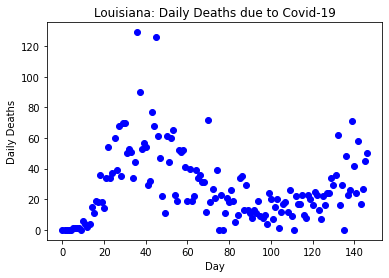

In [ ]:
# plot daily deaths
plt.plot(daily_deaths, 'bo')
plt.ylabel('Daily Deaths')
plt.xlabel("Day")
plt.title("Louisiana: Daily Deaths due to Covid-19")

In [ ]:
# The data appear to be non-linear, so we can try a polynomial least-squares fit
from numpy.polynomial import polynomial as P
x = np.linspace(1,147,147)
y = daily_deaths
fit = P.polyfit(x,y,3,full=False)

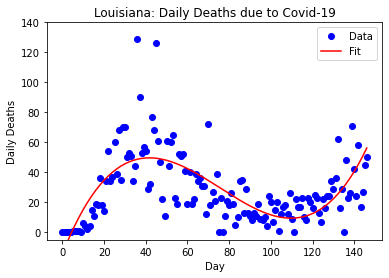

In [ ]:
y_pred = fit[3]*x**3 + fit[2]*x**2 + fit[1]*x + fit[0]
plt.plot(daily_deaths, 'bo', label="Data")
plt.plot(y_pred, 'red', label="Fit")
plt.ylabel('Daily Deaths')
plt.xlabel("Day")
plt.ylim((-5,140))
plt.title("Louisiana: Daily Deaths due to Covid-19")
plt.legend()

Text(0.5, 1.0, 'New York State: Daily Deaths due to Covid-19')

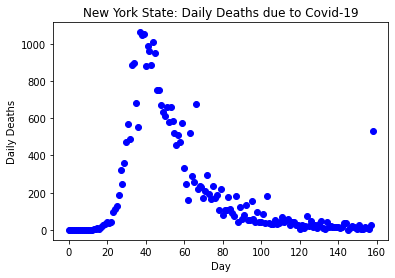

In [ ]:
loc_id = 555

# first calculate daily deaths. We can take the difference between each step of cumulative deaths.
df = covid_data.loc[covid_data.location_id == loc_id]
cum_deaths = df.deaths.values
daily_deaths = np.empty(len(cum_deaths))
daily_deaths[0] = cum_deaths[0]
for i in range(len(daily_deaths)):
    if i==0:
        daily_deaths[i] = cum_deaths[i]
    else:
        daily_deaths[i] = cum_deaths[i]-cum_deaths[i-1]

# plot daily deaths
plt.plot(daily_deaths, 'bo')
plt.ylabel('Daily Deaths')
plt.xlabel("Day")
plt.title("New York State: Daily Deaths due to Covid-19")

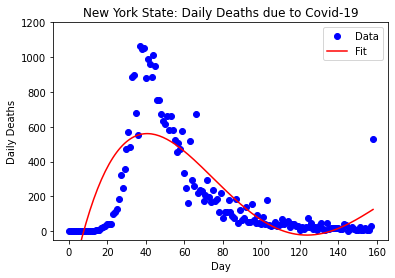

In [ ]:
x = np.linspace(1,159,159)
y = daily_deaths
fit = P.polyfit(x,y,4,full=False)

y_pred = fit[4]*x**4 + fit[3]*x**3 + fit[2]*x**2 + fit[1]*x + fit[0]
plt.plot(daily_deaths, 'bo', label="Data")
plt.plot(y_pred, 'red', label="Fit")
plt.ylabel('Daily Deaths')
plt.xlabel("Day")
plt.ylim((-50,1200))
plt.title("New York State: Daily Deaths due to Covid-19")
plt.legend()

2. My approach here would follow the same general steps of first plotting the daily deaths and determining the best type of curve fit by visual inspection. I do not think applying a general linear regression would be appropriate as we see the data can show nonlinear behavior. Correctly identifying the type of polynomial least-squares fit based on the shape of the data seems to produce a satisfactory result, but it is not always perfect. Daily deaths from New York show extreme spikes, so the polynomial degree would need to be tweaked to achieve a decent result. The fit here still captures the general trend, but the final outlier point pulls the curve upward, when we may expect the data to flatten out past 160 days. 

## 3.	Create projections for 14-days after the last observed data point. Visualize the result. Describe the benefits and limitations of your approach. Where do you think this approach has performed particularly well? What types of situations cause your model to struggle?

In [35]:
# make this a function
def compute_daily_deaths(df,loc_id):
    df = df.loc[df.location_id == loc_id]
    cum_deaths = df.deaths.values
    daily_deaths = np.empty(len(cum_deaths))
    daily_deaths[0] = cum_deaths[0]
    for i in range(len(daily_deaths)):
        if i==0:
            daily_deaths[i] = cum_deaths[i]
        else:
            daily_deaths[i] = cum_deaths[i]-cum_deaths[i-1]
    
    # some time steps are nan so setting these to zero so the model will give us valid coefficients
    return(np.nan_to_num(daily_deaths))

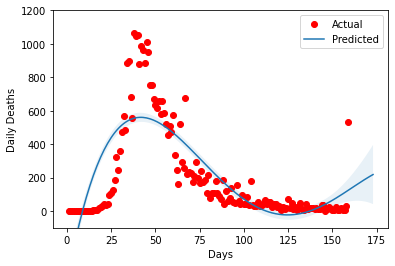

In [47]:
# first testing on this loc_id
loc_id = 555

# We will again fit a least-squares polynomial curve to each sequence, and then plot the predictions for 14 days in the future. 
y = compute_daily_deaths(covid_data, loc_id)
d = 4 # polynomial degree
n = len(y) # number of time steps
x = np.linspace(1,n+14,n+14) # point space

# do curve fitting and compute std. error using covariance matrix
p, cov = np.polyfit(x[:-14], y, d, cov=True)
TT = np.vstack([x**(d-i) for i in range(d+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(cov, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

fg, ax = plt.subplots(1, 1)
# ax.set_title("Fit for Polynomial (degree {}) with $\pm1\sigma$-interval".format(n))
ax.fill_between(x, yi+sig_yi, yi-sig_yi, alpha=.1)

ax.plot(x[:-14], y, 'ro')
ax.plot(x, yi,'-')
ax.set_ylim((-100,1200))
ax.set_xlabel("Days")
ax.set_ylabel("Daily Deaths")
ax.legend(['Actual', "Predicted"])
# ax.axis('tight')

This seemed to work so let's now iterate over all states.


Text(0.5, 0.9, 'Covid-19 Daily deaths (Projections up to 14 days)')

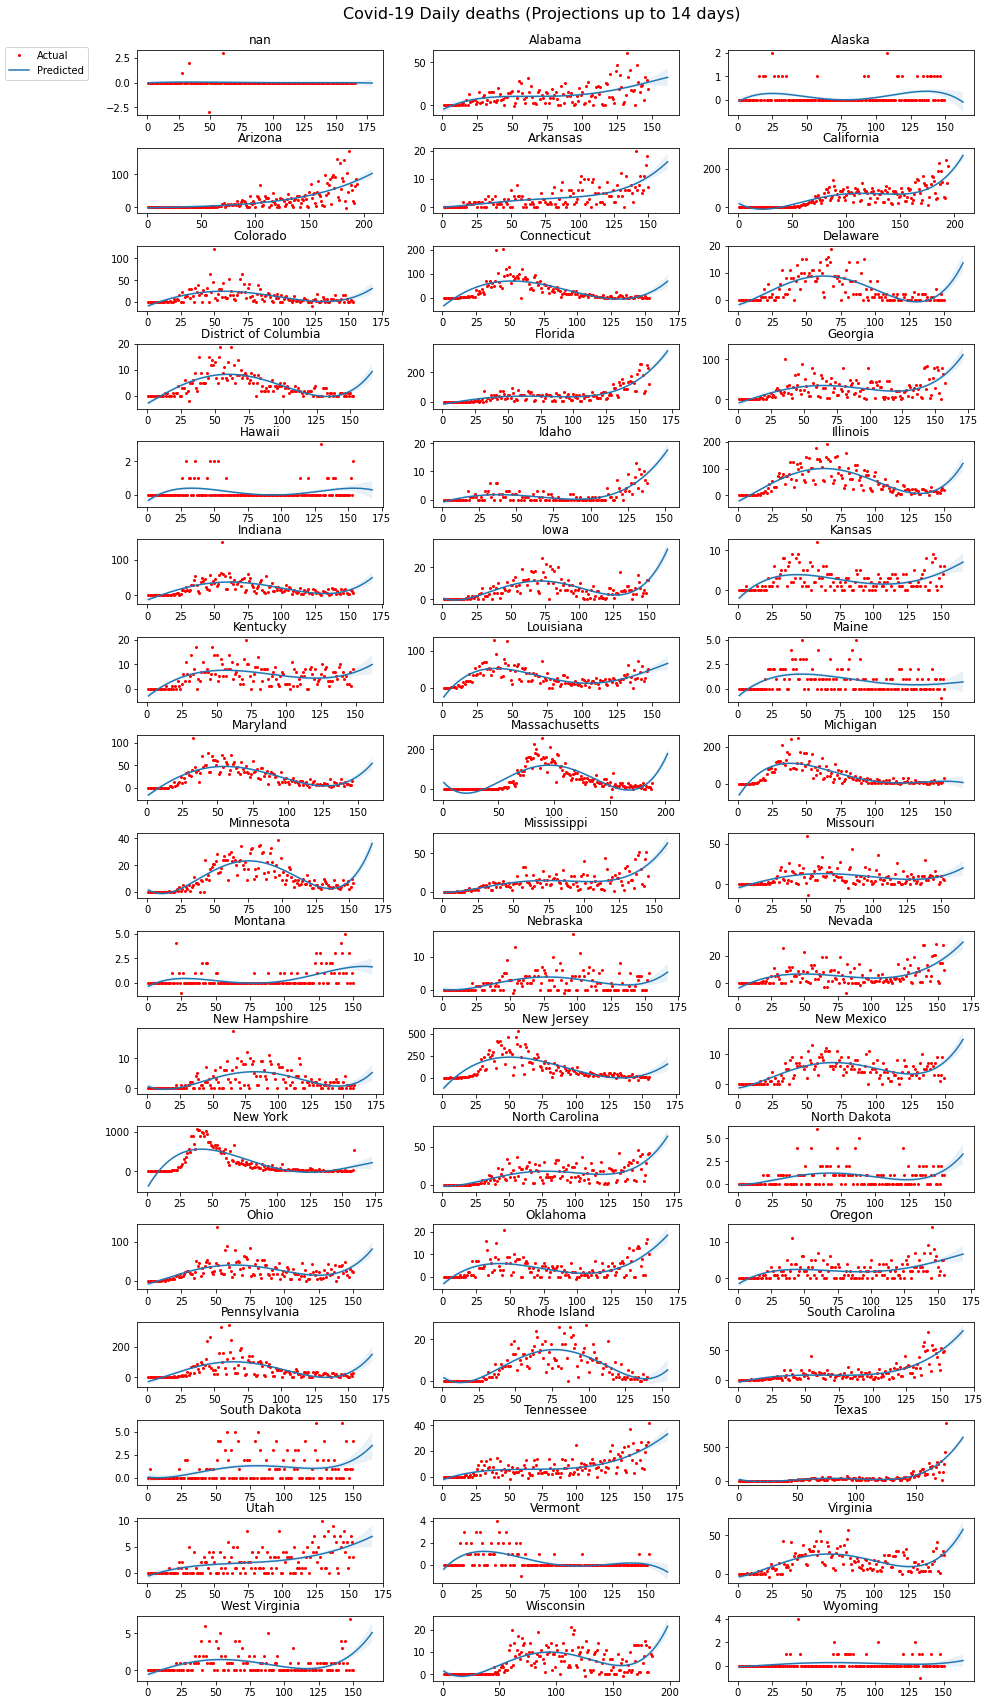

In [ ]:
# parameters
d = 4 # polynomial degree
np.seterr(all="ignore")
fig = plt.figure(figsize=(15,30))
plt.subplots_adjust(hspace=0.5)
pred_steps = 14 # number of time steps we are predicting
labels = ['Actual', 'Predicted']
for nn, loc_id in enumerate(loc_ids):
    df = covid_data.loc[covid_data.location_id == loc_id]
    y = compute_daily_deaths(covid_data, loc_id)
    n = len(y) # number of data points
    x = np.linspace(1,n+pred_steps,n+pred_steps) # point space

    # do curve fitting and compute std. error using covariance matrix
    p, cov = np.polyfit(x[:-14], y, d, cov=True)
    TT = np.vstack([x**(d-i) for i in range(d+1)]).T
    yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
    C_yi = np.dot(TT, np.dot(cov, TT.T)) # C_y = TT*C_z*TT.T
    sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

    ax = plt.subplot(17,3,nn+1)
    ax.fill_between(x, yi+sig_yi, yi-sig_yi, alpha=.1)

    ax.plot(x[:-14], y, 'ro', markersize='2')
    ax.plot(x, yi,'-')

    ax.axis('tight')
    ax.set_title(f"{df['state'].unique()[0]}")

fig.legend(labels, loc="upper left", bbox_to_anchor = (0,0.77))
fig.suptitle("Covid-19 Daily deaths (Projections up to 14 days)", y = 0.9, fontsize=16)

This approach appears to have worked well in instances where where daily deaths are non-sparse (either not 0 or missing), and where there are not too many outliers present, as least-squares fitting is particularly sensitive to outliers. Especially when deaths are sparse, in the case of Alaska, the curve fit does not seem particularly useful. I believe this method is sufficient at creating short-term predictions because it captures the general trend of the data in a small time frame. Making a long-term prediction would require consideration of seasonality and placing more importance on recent observations, so this model would not be appropriate for that case. If we want to answer the general question of "How can we expect deaths to change in the next few days?", I think this approach does exactly that and without the need for substantial computational resources. Since we are just fitting a curve, there is no need to train/test/validate a model either, so these outputs could be produced quickly if needed. 

## 4.	Lastly, describe future areas of exploration or improvement for your approach. If you had more time, what would you do next?

I would perhaps begin by refining the current model. I did no testing in regards to the degree of the polynomial fit. Due to time constraints it was chosen based on appearance. We saw that the same curve fit may not be appropriate in all cases, so refining the approach of choosing the polynomial degree for each case, in addition to imputing the data could lead to better results. If I had more time, I would like to explore machine learning or deep learning approaches to this problem. In particular I would try using an LSTM (long short-term memory) neural network, as they are well-suited for time series forecasting, and I already have some familiarty using them. This type of model would have a more robust application, not only being limited to short-term predictions. LSTM would help to capture long-term sequence patterns but still be applicable for short-term predictions, as we can adjust the "window" of inputs that go into each prediction. 